In [117]:
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import numpy as np
import warnings
import math
import re

tqdm.pandas()

plt.style.use('seaborn')

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

%run ../src/utils.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
train.shape

(814262, 11)

In [119]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
test.shape

(202937, 11)

In [120]:
data = pd.concat([train, test], axis=0)
data.shape

(1017199, 11)

# Timing
Time-related features

In [121]:
data['minute_entry'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))
data['minute_exit'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.progress_apply(lambda x: int(x.split(':')[0]))
data['hour_exit'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

In [122]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

data['deltat_min'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

# Distance Evaluation
Euclidian, Minkowski, Haversine distances.

In [123]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

def minkowski_distance(x_one, y_one, x_two, y_two):
    return abs(x_one-x_two) + abs(y_one-y_two)

data['euclidian_distance'] = np.sqrt(np.power(data.x_entry.values-data.x_exit.values, 2)+np.power(data.y_entry.values-data.y_exit.values, 2))

data['minkowski_distance'] = np.abs(data.x_entry.values-data.x_exit.values) + np.abs(data.y_entry.values-data.y_exit.values)

In [124]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

data['harvesine_distance'] = [haversine(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(data.x_entry, data.y_entry,
                                                                                data.x_exit, data.y_exit)]

In [125]:
data = data[data.euclidian_distance!=0]
data.shape

(491966, 19)

### Quadrants

In [126]:
x_center = center['x_min'] + ((center['x_max']-center['x_min'])/2)
y_center = center['y_min'] + ((center['y_max']+center['y_min'])/2)

In [127]:
def quadrant(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        

data['first_quadrant_entry'] = [quadrant(x, y, which='first') for x, y in zip(data.x_entry, data.y_entry)]
data['third_quadrant_entry'] = [quadrant(x, y, which='third') for x, y in zip(data.x_entry, data.y_entry)]
data['fourth_quadrant_entry'] = [quadrant(x, y, which='fourth') for x, y in zip(data.x_entry, data.y_entry)]
data['second_quadrant_entry'] = [quadrant(x, y, which='second') for x, y in zip(data.x_entry, data.y_entry)]

### Distances to Center Middle Point

In [128]:
data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

data['diff_cc_exit_entry'] = data.distance_cc_exit - data.distance_cc_entry

In [129]:
data['x_diff_entry'] = data.x_entry.values-x_center
data['x_diff_exit'] = data.x_exit.values-x_center

data['y_diff_entry'] = data.y_entry.values-y_center
data['y_diff_exit'] = data.y_exit.values-y_center

In [130]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [131]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

### Distances from Center Borders
Euclidian distance from point to city center borders.

In [132]:
from shapely.geometry import Point, Polygon, LineString

center['left_border']  = LineString([(center['x_min'], center['y_min']), (center['x_min'], center['y_max'])])
center['right_border'] = LineString([(center['x_max'], center['y_min']), (center['x_max'], center['y_max'])])

center['lower_border']  = LineString([(center['x_min'], center['y_min']), (center['x_max'], center['y_min'])])
center['upper_border']  = LineString([(center['x_min'], center['y_max']), (center['x_max'], center['y_max'])])

center['left_border'].distance(Point(center['x_max'], center['y_min']))

20000.0

In [133]:
def distance_to_border(x, y, direction):
    return center[direction + '_border'].distance(Point(x, y))

data['distance_left_border'] = [distance_to_border(x, y, direction='left') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_right_border'] = [distance_to_border(x, y, direction='right') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_lower_border'] = [distance_to_border(x, y, direction='lower') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_upper_border'] = [distance_to_border(x, y, direction='upper') for x, y in zip(data.x_entry, data.y_entry)]

# Angles w.r.t Center
Mid and vertex-related angles on a per point basis

In [134]:
data['last_x_entry'] = data.groupby('hash').x_exit.shift(1)
data['last_y_entry'] = data.groupby('hash').y_exit.shift(1)

angle_cols = [
    'cc_middle_angle', 'cc_xmin_ymin_angle', 'cc_xmax_ymin_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymax_angle'
]

data = data.reindex(columns=data.columns.tolist() + angle_cols)

data = data.progress_apply(entry_to_center_angles, axis=1)

data = data.drop(columns=['last_x_entry', 'last_y_entry'])

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-0.000546,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-0.000830,54012.799354,59966.283785,54012.799354,113775.281047,0.137059,0.038653,0.188293,0.042244,0.310604
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-0.000837,25386.747582,35858.533322,25386.747582,84874.048910,0.198812,0.120334,0.476339,0.057555,0.234039
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-0.000837,24146.972686,34984.767305,24146.972686,83601.282594,0.173281,0.132425,0.711798,0.044184,0.184758


In [135]:
data[angle_cols] = data[angle_cols] * 180.0 / np.pi
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-0.000546,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-0.000830,54012.799354,59966.283785,54012.799354,113775.281047,7.852886,2.214659,10.788397,2.420383,17.796301
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-0.000837,25386.747582,35858.533322,25386.747582,84874.048910,11.391105,6.894649,27.292186,3.297664,13.409474
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-0.000837,24146.972686,34984.767305,24146.972686,83601.282594,9.928271,7.587407,40.782997,2.531528,10.585844


# Target feature

In [136]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

# Grid Sections
We'll start off dividing our trajectory map in grids meant to cover any posible entry point in our data

In [137]:
xmin, ymin, xmax, ymax = data.x_entry.min(), data.y_entry.min(), data.x_entry.max(), data.y_entry.max()

xmax-xmin, ymax-ymin

(36068.62821192667, 340258.3224131949)

In [138]:
from shapely.geometry import Polygon

# 10x3 grids, given the height/width ratio is predominantly vertical
y_count = 4
x_count = 10

grid_h = (ymax-ymin)/y_count
grid_w = (xmax-xmin)/x_count

grids = {'{}_{}'.format(i+1,j+1): Polygon([
            (xmin + grid_w*i, ymin + grid_h*j), (xmin + grid_w*i, ymin + grid_h*(j+1)),
            (xmin + grid_w*(i+1), ymin + grid_h*(j+1)), (xmin + grid_w*(i+1), ymin + grid_h*j)]) \
         for i in range(0, x_count) \
         for j in range(0, y_count)}

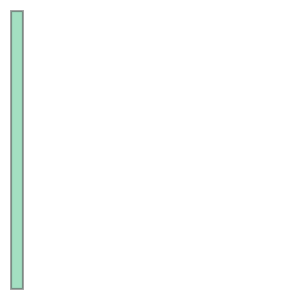

In [139]:
grids['1_1']

In [140]:
grid_cols = ['entry_grid_' + grid for grid in grids.keys()]
data = data.reindex(columns=data.columns.tolist() + grid_cols)

In [141]:
for (_, grid), col in zip(grids.items(), grid_cols):
    data[col] = data.apply(lambda row: grid.contains(Point(row['x_entry'], row['y_entry'])), axis=1)

In [142]:
data[grid_cols] = data[grid_cols].astype(int)

In [143]:
for col in grid_cols:
    data.loc[data[col] == 1, 'neighbors'] = data[col].sum()

data.head(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,entry_grid_8_4,entry_grid_9_1,entry_grid_9_2,entry_grid_9_3,entry_grid_9_4,entry_grid_10_1,entry_grid_10_2,entry_grid_10_3,entry_grid_10_4,neighbors
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,0,0,0,0,0,0,0,0,4034.0
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,0,0,0,0,0,0,0,0,11235.0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,0,0,0,0,0,0,0,0,24758.0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,0,0,0,0,0,0,0,0,24758.0
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,0,0,0,0,0,0,0,0,0,24758.0


In [144]:
data['center_permanency'] = data.progress_apply(center_permanency, axis=1)

In [145]:
# time passed between blind spots

data['time_delta_blind'] = (data.time_entry - data.time_exit.shift(1)) / np.timedelta64(1, 'm')

In [146]:
# time passed between blind spots

data['x_delta_blind'] = data.x_entry - data.x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.y_exit.shift(1)

data['distance_blind'] = ((data.x_delta_blind**2) + (data.y_delta_blind)**2)**(1/2)

data.loc[data.time_delta_blind < 0, 'distance_blind'] = 0

data.loc[data.time_delta_blind < 0, 'x_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'y_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'time_delta_blind'] = 0

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,entry_grid_10_1,entry_grid_10_2,entry_grid_10_3,entry_grid_10_4,neighbors,center_permanency,time_delta_blind,x_delta_blind,y_delta_blind,distance_blind
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,0,0,0,4034.0,0.0,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,0,0,0,11235.0,0.0,12.033333,-6388.625577,-186127.626359,186237.235350
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,0,0,0,24758.0,0.0,27.833333,-106.866711,26098.775095,26098.993888
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,0,0,0,24758.0,0.0,14.416667,64.565305,551.388913,555.156205


In [147]:
data['trajectory_number'] = data.trajectory_id.progress_apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

data.loc[data.trajectory_number==0, 'distance_blind'] = 0
data.loc[data.trajectory_number==0, 'time_delta_blind'] = 0

# Time: Continuous features

In [149]:
data['hours_continuous'] = [t / pd.Timedelta(hours=1) for t in data.time_entry]
data['minutes_continuous'] = [t / pd.Timedelta(minutes=1) for t in data.time_entry]

# Trajectories' Origin Point Features

It is a logical estimate that an extensive group in all recorded trajectories will eventually return to their origin point in the day - relating, in this case, to a person's return home. Dealing with paths distributed in space and time, the current-point to origin-point correlation levels hold a considerable chance to be proportional to any either spatial coordinates, time, or both.

With that in mind, let us then compute features focused on current-to-origin point differences.

In [199]:
col_subset = ['time_entry', 'time_exit', 'x_entry', 'y_entry', 'x_exit', 'y_exit']
data[[f'last_{c}' for c in col_subset]] = data.groupby('hash')[col_subset].shift(1)

origin_points = data.groupby('hash').nth(0)[col_subset]
origin_points.columns = [f'origin_{c}' for c in col_subset]

In [200]:
if data.columns.contains('origin_time_entry'):
    data = data[data.columns.drop(col_subset)]

data = data.merge(origin_points, on='hash')

In [213]:
for p in ['last', 'origin']:
    data[f'deltat_{p}_entry'] = (data.time_entry - data[f'{p}_time_entry']) / pd.Timedelta(minutes=1)
    data[f'deltat_{p}_exit'] = (data.time_entry - data[f'{p}_time_exit']) / pd.Timedelta(minutes=1)

    data = data[data.columns.drop([x for x in data.columns.ravel() if x.startswith(f'{p}_time_')])]

    data[f'deltad_{p}_entry'] = euclidian_distance(data[f'{p}_x_entry'], data[f'{p}_y_entry'], data.x_entry, data.y_entry)
    data[f'deltad_{p}_exit'] = euclidian_distance(data[f'{p}_x_exit'], data[f'{p}_y_exit'], data.x_entry, data.y_entry)

data.head(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,deltad_last_entry,deltad_last_exit,deltat_origin_entry,deltat_origin_exit,deltad_origin_entry,deltad_origin_exit,origin_x_entry,origin_y_entry,origin_x_exit,origin_y_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,0.000000,-4.016667,0.000000,42364.863118,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,228596.463182,186237.235350,16.050000,12.033333,228596.463182,186237.235350,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,28917.602551,26098.993888,49.016667,45.000000,199678.885516,157319.709924,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,1275.217661,555.156205,73.316667,69.300000,198403.955748,156044.897162,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,10456.116584,8653.813042,478.000000,473.983333,187951.218338,145593.405664,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07


### Aggregating features

In [215]:
window_reference = 5

cols_to_agg = ['vmax', 'vmin', 'vmean', 'x_entry', 'y_entry', 'minute_entry', 'hours_continuous', 'minutes_continuous',
               'hour_entry', 'first_quadrant_entry', 'third_quadrant_entry', 'fourth_quadrant_entry', 'second_quadrant_entry',
               'trajectory_number', 'distance_cc_entry', 'deltat_min', 'x_diff_entry', 'y_diff_entry', 'direction_entry',
               'distance_left_border', 'distance_right_border', 'distance_lower_border', 'distance_upper_border'] + angle_cols

agg_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg]
                .mean()
                .shift(1)
                .rolling(window_reference, min_periods=1)
                .agg(['mean', 'max', 'std', 'min', 'sum']))

agg_features.columns = ["_".join(x) for x in agg_features.columns.ravel()]
data = data.merge(agg_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,cc_xmin_ymax_angle_mean,cc_xmin_ymax_angle_max,cc_xmin_ymax_angle_std,cc_xmin_ymax_angle_min,cc_xmin_ymax_angle_sum,cc_xmax_ymax_angle_mean,cc_xmax_ymax_angle_max,cc_xmax_ymax_angle_std,cc_xmax_ymax_angle_min,cc_xmax_ymax_angle_sum
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,2.420383,2.420383,NaN,2.420383,2.420383,17.796301,17.796301,NaN,17.796301,17.796301
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,2.859023,3.297664,0.620331,2.420383,5.718046,15.602887,17.796301,3.101955,13.409474,31.205774


# Sequence Data

In [216]:
window_reference = 5

grouped = data.groupby(['hash']).tail(window_reference)
grouped['sequence'] = np.ones(grouped.shape[0])
df = grouped.groupby(by=['hash','time_entry', 'trajectory_id']).sum().groupby(level=[0]).cumsum().reset_index()[['trajectory_id', 'sequence']]
df.columns = ['trajectory_id', 'trajectory_sequence']
grouped = grouped.merge(df, on='trajectory_id', how='left')

In [217]:
hash_count_trajectories = grouped.groupby(['hash']).trajectory_id.count().reset_index()
hash_count_trajectories.columns = ['hash', 'count_trajectories']

grouped = grouped.merge(hash_count_trajectories, on='hash', how='left')
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,cc_xmin_ymax_angle_min,cc_xmin_ymax_angle_sum,cc_xmax_ymax_angle_mean,cc_xmax_ymax_angle_max,cc_xmax_ymax_angle_std,cc_xmax_ymax_angle_min,cc_xmax_ymax_angle_sum,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,2.420383,2.420383,17.796301,17.796301,NaN,17.796301,17.796301,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,2.420383,5.718046,15.602887,17.796301,3.101955,13.409474,31.205774,1.0,4.0,5


In [218]:
ref = window_reference
for i in range(1, window_reference):
    grouped.loc[grouped.count_trajectories==i, 'trajectory_sequence'] += ref-1
    ref -= 1
    
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,cc_xmin_ymax_angle_min,cc_xmin_ymax_angle_sum,cc_xmax_ymax_angle_mean,cc_xmax_ymax_angle_max,cc_xmax_ymax_angle_std,cc_xmax_ymax_angle_min,cc_xmax_ymax_angle_sum,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,2.420383,2.420383,17.796301,17.796301,NaN,17.796301,17.796301,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,2.420383,5.718046,15.602887,17.796301,3.101955,13.409474,31.205774,1.0,4.0,5


In [219]:
grouped = grouped.drop('sequence', axis=1)
#grouped['traje']

In [220]:
data_sequence = grouped.groupby(['hash', 'trajectory_sequence']).mean().unstack()
data_sequence.shape

(144216, 1225)

In [221]:
data_sequence.columns = ['_'.join([x[0], str(int(x[1]))]) for x in data_sequence.columns.ravel()]
data_sequence.head(3)

,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,vmin_5,...,cc_xmax_ymax_angle_sum_1,cc_xmax_ymax_angle_sum_2,cc_xmax_ymax_angle_sum_3,cc_xmax_ymax_angle_sum_4,cc_xmax_ymax_angle_sum_5,count_trajectories_1,count_trajectories_2,count_trajectories_3,count_trajectories_4,count_trajectories_5
hash,,,,,,,,,,,,,,,,,,,,,
0000a8602cf2def930488dee7cdad104_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17.796301,31.205774,41.791618,5.0,5.0,5.0,5.0,5.0
0000cf177130469eeac79f67b6bcf3df_9,NaN,NaN,NaN,NaN,1.149404,NaN,NaN,NaN,NaN,1.149404,...,NaN,NaN,NaN,NaN,58.628646,NaN,NaN,NaN,NaN,1.0
0001f97b99a80f18f62e2d44e54ef33d_3,NaN,NaN,NaN,32.196255,30.167742,NaN,NaN,NaN,32.196255,30.167742,...,NaN,NaN,NaN,58.628646,40.832345,NaN,NaN,NaN,2.0,2.0


In [222]:
data_sequence = data_sequence.reset_index()

In [223]:
data_sequence.shape

(144216, 1226)

In [224]:
data_train = data_sequence[data_sequence['hour_exit_'+str(window_reference)]==15]
data_train.shape

(100404, 1226)

In [225]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

(66898, 1226)

In [226]:
drop_cols = list(x for x in data.columns if 'exit' in x) + grid_cols
drop_cols += ['euclidian_distance', 'minkowski_distance', 'harvesine_distance',
              'center_permanency', 'has_crossed_city', 'velocity']

drop_cols = [col+'_'+str(window_reference) for col in drop_cols]
drop_cols += [col+'_'+str(i) for col in grid_cols for i in range(0, 5)]
drop_cols += ['hash']

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [227]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.2, random_state=20)
dt_train.shape, dt_test.shape

((53518, 1226), (13380, 1226))

In [228]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

clf = LGBMClassifier(n_estimators=150, max_features=0.5, seed=20)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.7465277777777779

In [465]:
# Score 0.7432216905901117 | 0.89358
# Score 0.7413765697027499 | 0.89307 - n_estimators=150, max_features=0.5

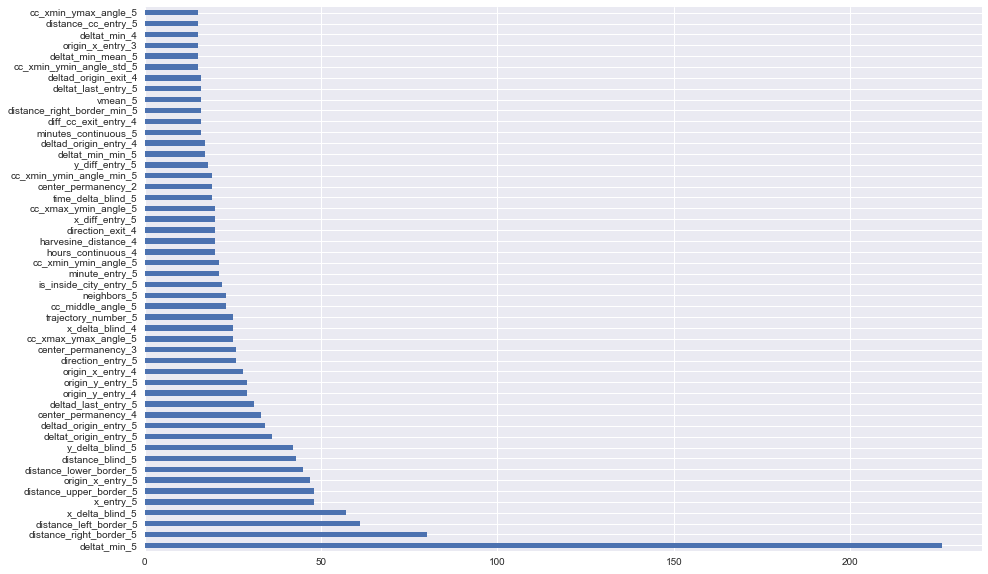

In [229]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(50).plot(kind='barh')

In [230]:
data_test = data_sequence[data_sequence.hash.isin(hashs_test)]
#data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [231]:
data_test.shape

(33515, 1226)

In [232]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [233]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [234]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

In [235]:
pd.Series(yhat).value_counts()

0.0    24999
1.0     8516
dtype: int64

In [236]:
data_test.head(4)

,hash,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,...,cc_xmax_ymax_angle_sum_2,cc_xmax_ymax_angle_sum_3,cc_xmax_ymax_angle_sum_4,cc_xmax_ymax_angle_sum_5,count_trajectories_1,count_trajectories_2,count_trajectories_3,count_trajectories_4,count_trajectories_5,trajectory_id
0,00032f51796fd5437b238e3a9823d13d_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.19844,92.19844,73.871410,58.981582,NaN,4.0,4.0,4.0,4.0,traj_00032f51796fd5437b238e3a9823d13d_31_5
1,000479418b5561ab694a2870cc04fd43_25,NaN,NaN,17.29,NaN,NaN,NaN,NaN,17.29,NaN,...,NaN,41.06429,7.750636,16.472289,NaN,NaN,3.0,3.0,3.0,traj_000479418b5561ab694a2870cc04fd43_25_10
2,000506a39775e5bca661ac80e3f466eb_29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25.750249,16.177021,NaN,NaN,NaN,2.0,2.0,traj_000506a39775e5bca661ac80e3f466eb_29_5
3,0005401ceddaf27a9b7f0d42ef1fbe95_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21.513777,NaN,NaN,NaN,NaN,1.0,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4


In [237]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [238]:
submission.to_csv('../data/submission42_julio.csv', index=False)

# Preprocessed Data Saving

In [252]:
data_sequence.to_hdf('../data/preprocessed/data_sequence_0.89441.hdf', key='origin_deltas', mode='w')

ImportError: HDFStore requires PyTables, "DLL load failed: Não foi possível encontrar o procedimento especificado." problem importing